In [1]:
import os

api_key = os.environ.get("OPENAI_API_KEY")
if api_key is None:
    print("API key is not set.")
else:
    print("API key is set.")


API key is set.


In [2]:
import torch
from torch.autograd import Variable as V
import torchvision.models as models
from torchvision import transforms as trn
from torch.nn import functional as F
import numpy as np
import cv2
from PIL import Image, ImageDraw, ImageFont
import openai
from openai import OpenAI
import textwrap
import requests

import urllib.request
import base64

In [3]:
img_list = []

response = requests.get('http://localhost:5000/process_images')

# Ensure the request was successful
if response.status_code == 200:
    image_urls = response.json()  # this will be your list of image URLs
else:
    print("Image URLS Unsuccessful")

final_image = Image.new("RGB", (len(image_urls) * 256, 5 * 256), "white")
    
for i in range(len(image_urls)):
    with urllib.request.urlopen(image_urls[i]) as response:
        with open(f"image{i}.png", "wb") as f:
            
            f.write(response.read())
            img_list.append(f"image{i}.png")
            image = Image.open(f"image{i}.png")
            final_image.paste(image, (i * 256, 0))


print(img_list)            
final_image.show()

    
# with open("image1.png", "rb") as f:
#     encoded_image = base64.b64encode(f.read()).decode("utf-8")        
        
# new_google_url = f"data:image/jpeg;base64,{encoded_image}"
# image1 = Image.open("image1.png")
# image1.show()


['image0.png', 'image1.png', 'image2.png', 'image3.png', 'image4.png']


In [4]:
 # hacky way to deal with the Pytorch 1.0 update
def recursion_change_bn(module):
    if isinstance(module, torch.nn.BatchNorm2d):
        module.track_running_stats = 1
    else:
        for i, (name, module1) in enumerate(module._modules.items()):
            module1 = recursion_change_bn(module1)
    return module

def load_labels():
    # prepare all the labels
    # scene category relevant
    file_name_category = 'categories_places365.txt'
    if not os.access(file_name_category, os.W_OK):
        synset_url = 'https://raw.githubusercontent.com/csailvision/places365/master/categories_places365.txt'
        os.system('wget ' + synset_url)
    classes = list()
    with open(file_name_category) as class_file:
        for line in class_file:
            classes.append(line.strip().split(' ')[0][3:])
    classes = tuple(classes)

    # indoor and outdoor relevant
    file_name_IO = 'IO_places365.txt'
    if not os.access(file_name_IO, os.W_OK):
        synset_url = 'https://raw.githubusercontent.com/csailvision/places365/master/IO_places365.txt'
        os.system('wget ' + synset_url)
    with open(file_name_IO) as f:
        lines = f.readlines()
        labels_IO = []
        for line in lines:
            items = line.rstrip().split()
            labels_IO.append(int(items[-1]) -1) # 0 is indoor, 1 is outdoor
    labels_IO = np.array(labels_IO)

    # scene attribute relevant
    file_name_attribute = 'labels_sunattribute.txt'
    if not os.access(file_name_attribute, os.W_OK):
        synset_url = 'https://raw.githubusercontent.com/csailvision/places365/master/labels_sunattribute.txt'
        os.system('wget ' + synset_url)
    with open(file_name_attribute) as f:
        lines = f.readlines()
        labels_attribute = [item.rstrip() for item in lines]
    file_name_W = 'W_sceneattribute_wideresnet18.npy'
    if not os.access(file_name_W, os.W_OK):
        synset_url = 'http://places2.csail.mit.edu/models_places365/W_sceneattribute_wideresnet18.npy'
        os.system('wget ' + synset_url)
    W_attribute = np.load(file_name_W)

    return classes, labels_IO, labels_attribute, W_attribute

def hook_feature(module, input, output):
    features_blobs.append(np.squeeze(output.data.cpu().numpy()))

def returnCAM(feature_conv, weight_softmax, class_idx):
    # generate the class activation maps upsample to 256x256
    size_upsample = (256, 256)
    nc, h, w = feature_conv.shape
    output_cam = []
    for idx in class_idx:
        cam = weight_softmax[class_idx].dot(feature_conv.reshape((nc, h*w)))
        cam = cam.reshape(h, w)
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(cv2.resize(cam_img, size_upsample))
    return output_cam

def returnTF():
# load the image transformer
    tf = trn.Compose([
        trn.Resize((224,224)),
        trn.ToTensor(),
        trn.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    return tf


def load_model():
    # this model has a last conv feature map as 14x14

    model_file = 'wideresnet18_places365.pth.tar'
    if not os.access(model_file, os.W_OK):
        os.system('wget http://places2.csail.mit.edu/models_places365/' + model_file)
        os.system('wget https://raw.githubusercontent.com/csailvision/places365/master/wideresnet.py')

    import wideresnet
    model = wideresnet.resnet18(num_classes=365)
    checkpoint = torch.load(model_file, map_location=lambda storage, loc: storage)
    state_dict = {str.replace(k,'module.',''): v for k,v in checkpoint['state_dict'].items()}
    model.load_state_dict(state_dict)
    
    # hacky way to deal with the upgraded batchnorm2D and avgpool layers...
    for i, (name, module) in enumerate(model._modules.items()):
        module = recursion_change_bn(model)
    model.avgpool = torch.nn.AvgPool2d(kernel_size=14, stride=1, padding=0)
    
    model.eval()



    # the following is deprecated, everything is migrated to python36

    ## if you encounter the UnicodeDecodeError when use python3 to load the model, add the following line will fix it. Thanks to @soravux
    #from functools import partial
    #import pickle
    #pickle.load = partial(pickle.load, encoding="latin1")
    #pickle.Unpickler = partial(pickle.Unpickler, encoding="latin1")
    #model = torch.load(model_file, map_location=lambda storage, loc: storage, pickle_module=pickle)

    model.eval()
    # hook the feature extractor
    features_names = ['layer4','avgpool'] # this is the last conv layer of the resnet
    for name in features_names:
        model._modules.get(name).register_forward_hook(hook_feature)
    return model


--TYPE OF ENVIRONMENT: outdoor
--SCENE CATEGORIES:
0.239 -> industrial_area
0.155 -> parking_lot
0.122 -> crosswalk
0.085 -> residential_neighborhood
0.036 -> fire_station
Prompt: industrial_area man-made, natural light, open area, driving, asphalt, sunny, biking, pavement, transporting, clouds, dry, trees, no horizon, far-away horizon


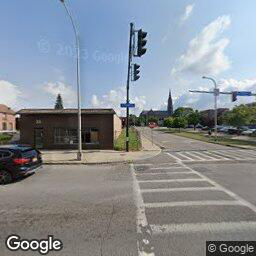

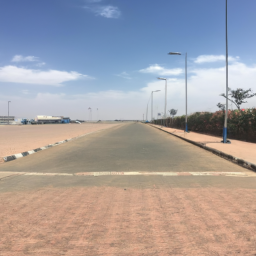

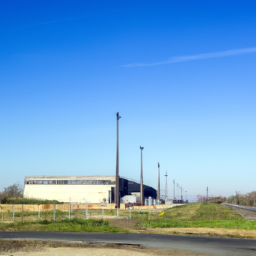

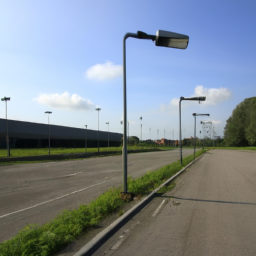

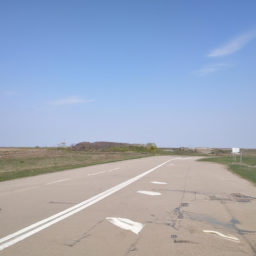

--TYPE OF ENVIRONMENT: outdoor
--SCENE CATEGORIES:
0.110 -> loading_dock
0.077 -> parking_garage/outdoor
0.046 -> beach_house
0.034 -> manufactured_home
0.033 -> library/outdoor
Prompt: loading_dock man-made, natural light, open area, no horizon, glass, sunny, driving, asphalt, pavement, brick, shingles, biking, vertical components, dry


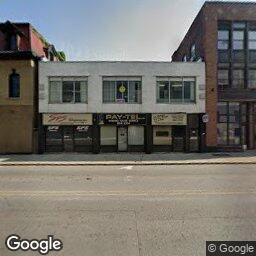

RateLimitError: Error code: 429 - {'error': {'code': 'rate_limit_exceeded', 'message': 'Rate limit exceeded for images per minute in organization org-Uj37C4Ps1YoK6w2mD62OaMV5. Limit: 5/1min. Current: 8/1min. Please visit https://platform.openai.com/docs/guides/rate-limits to learn how to increase your rate limit.', 'param': None, 'type': 'requests'}}

In [16]:
count = 1
for i in img_list:
        # load the labels
    classes, labels_IO, labels_attribute, W_attribute = load_labels()

    # load the model
    features_blobs = []
    model = load_model()

    # load the transformer
    tf = returnTF() # image transformer

    # get the softmax weight
    params = list(model.parameters())
    weight_softmax = params[-2].data.numpy()
    weight_softmax[weight_softmax<0] = 0

    # load the test image
    # img_url = 'https://images2.minutemediacdn.com/image/upload/c_fill,w_1080,ar_16:9,f_auto,q_auto,g_auto/shape%2Fcover%2Fsport%2F604599-gettyimages-1083893950-458b5d23ecd7e3642caa7280f596693d.jpg'
    # img_url = 'https://upload.wikimedia.org/wikipedia/commons/a/ac/Transit_Road.jpg'
    # img_url = new_google_url
    # os.system('wget %s -q -O test.jpg' % img_url)
#     img = Image.open(i)
    # img.show()



    # with urllib.request.urlopen(img_url) as img_url:
    #     with open("image2.png", "wb") as img:
    #         img.write(img_url.read())

    # image2 = Image.open("image2.png")
    # image2.show()

    # print(new_google_url)
    img = Image.open(i)
    img.save(i)
    input_img = V(tf(img).unsqueeze(0))

# forward pass


    logit = model.forward(input_img)
    h_x = F.softmax(logit, 1).data.squeeze()
    probs, idx = h_x.sort(0, True)
    probs = probs.numpy()
    idx = idx.numpy()

    # print('RESULT ON ' + str(img_url))

    # output the IO prediction
    io_image = np.mean(labels_IO[idx[:10]]) # vote for the indoor or outdoor
    if io_image < 0.5:
        print('--TYPE OF ENVIRONMENT: indoor')
    else:
        print('--TYPE OF ENVIRONMENT: outdoor')

    # output the prediction of scene category
    scene_categories = ""
    print('--SCENE CATEGORIES:')
    for j in range(0, 5):
        print('{:.3f} -> {}'.format(probs[j], classes[idx[j]]))
        scene_categories += '{:.3f} -> {}'.format(probs[j], classes[idx[j]]) + '\n'

    # output the scene attributes
    responses_attribute = W_attribute.dot(features_blobs[1])
    idx_a = np.argsort(responses_attribute)
#     print('--SCENE ATTRIBUTES:')
#     print(', '.join([labels_attribute[idx_a[i]] for i in range(-1,-15,-1)]))

    # OpenAI DALL-E generation
    PROMPT = '{:.3f} -> {}'.format(probs[0], classes[idx[0]])[9:] + " " +  ', '.join([labels_attribute[idx_a[i]] for i in range(-1,-15,-1)])
    print("Prompt: " + PROMPT)
    wrapped_prompt = textwrap.wrap(PROMPT, width=20)
#     img.show()
    display(img)
    response = OpenAI().images.generate(
        model="dall-e-2",
        prompt=PROMPT,
        n=4,
        size="256x256",
        quality="standard",
    )

#     print(response["data"][0]["url"])
    for img_data in response.data:
        url = img_data.url
        with urllib.request.urlopen(url) as url:
            with open("image.png", "wb") as img:
                img.write(url.read())

        DALLE_img = Image.open("image.png")
        display(DALLE_img)
        DALLE_img.save(f"/Unattributable/unattributable-urbanism/dalle-imgs/DALLE_image_{count}.png")
#     DALLE_img.show()

        # generate class activation mapping
#         print('Class activation map is saved as cam.jpg')
        CAMs = returnCAM(features_blobs[0], weight_softmax, [idx[0]])

        # render the CAM and output

    img = cv2.imread(i)
    height, width, _ = img.shape
    heatmap = cv2.applyColorMap(cv2.resize(CAMs[0],(width, height)), cv2.COLORMAP_JET)
    result = heatmap * 0.4 + img * 0.5
    cv2.imwrite(f'cam {str(i)[0:6]}.jpg', result)
    heatmapimg = Image.open(f'cam {str(i)[0:6]}.jpg')
    dalleimg = Image.open(f'dalle-imgs/DALLE_image_{count}.png')
    places_categories_img = Image.new("RGB", (256, 256), color = (255, 255, 255))
    prompt_img = Image.new("RGB", (256, 256), color = (255, 255, 255))
    font = ImageFont.truetype('/fonts/arial.ttf', 14)
    draw_categories = ImageDraw.Draw(places_categories_img)
    draw_categories.text((10, 10), scene_categories, font=font, fill=(0, 0, 0))
    draw_prompt = ImageDraw.Draw(prompt_img)
    x = 10
    y = 10
    for line in wrapped_prompt:
        text_width = draw_prompt.textlength(line, font=font)
        draw_prompt.text((x, y), line, font=font, fill=(0, 0, 0))
        text_height = font.size
        y += text_height
    final_image.paste(heatmapimg, ((count - 1) * 256, 256))
    final_image.paste(places_categories_img, ((count - 1) * 256, 2 * 256))
    final_image.paste(prompt_img, ((count - 1) * 256, 640))
    final_image.paste(dalleimg, ((count - 1) * 256, 896))
    count += 1

    
final_image.show()
final_image.save('final_image.jpg')